<a href="https://colab.research.google.com/github/chrismartel/ECSE415-Project-G7/blob/main/tracking/sowce_tracking_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ECSE_415/Final_project

/content/drive/MyDrive/ECSE_415/Final_project


In [3]:
from data import download_datasets
import cv2
import sys
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import os
from os import listdir

In [4]:
download_datasets(['ecse415'])

In [5]:
sequence_path = "/content/drive/MyDrive/ECSE_415/Final_project/dataset/0003"

In [6]:
%cd /content/drive/MyDrive/ECSE_415/Final_project/dataset/0003


/content/drive/MyDrive/ECSE_415/Final_project/dataset/0003


In [7]:
!ls

000000.png  000024.png	000048.png  000072.png	000096.png  000120.png
000001.png  000025.png	000049.png  000073.png	000097.png  000121.png
000002.png  000026.png	000050.png  000074.png	000098.png  000122.png
000003.png  000027.png	000051.png  000075.png	000099.png  000123.png
000004.png  000028.png	000052.png  000076.png	000100.png  000124.png
000005.png  000029.png	000053.png  000077.png	000101.png  000125.png
000006.png  000030.png	000054.png  000078.png	000102.png  000126.png
000007.png  000031.png	000055.png  000079.png	000103.png  000127.png
000008.png  000032.png	000056.png  000080.png	000104.png  000128.png
000009.png  000033.png	000057.png  000081.png	000105.png  000129.png
000010.png  000034.png	000058.png  000082.png	000106.png  000130.png
000011.png  000035.png	000059.png  000083.png	000107.png  000131.png
000012.png  000036.png	000060.png  000084.png	000108.png  000132.png
000013.png  000037.png	000061.png  000085.png	000109.png  000133.png
000014.png  000038.png	000062.png 

In [44]:
video_sequence = []

for image in sorted(os.listdir(sequence_path)):

  # check if the image ends with png
  if (image.endswith(".png")):

    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    video_sequence.append(img_rgb)

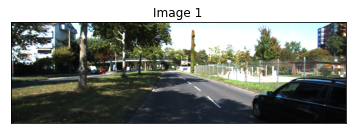

In [32]:
# Show the first image of the video sequence
plt.title("Image 1"), plt.xticks([]), plt.yticks([])
plt.imshow(video_sequence[0])

In [45]:
path = "/content/drive/MyDrive/ECSE_415/Final_project"

fig = plt.figure()

# Set up tracker.
# You have following options; uncomment one of these.

#tracker2 = cv2.TrackerBoosting_create()
# tracker = cv2.TrackerMIL_create()
#tracker = cv2.TrackerMedianFlow_create()
tracker = cv2.TrackerTLD_create()

# Read first frame.
frame4 = video_sequence[0]

display(frame4.shape)

# Define an initial bounding box
bbox = (894, 190, 340, 180) #292.43732, 176.91368, 331.77728, 197.46696  /////  894.7683,  190.6503, 1241.    ,  374.  

# Initialize tracker with first frame and bounding box
ok = tracker.init(frame4, bbox)
display(ok)

ims = []
for i in range(len(video_sequence)-1):
  frame4 = video_sequence[i+1]

  ok, bbox = tracker.update(frame4)

  # Tracking success
  p1 = (int(bbox[0]), int(bbox[1]))
  p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
  cv2.rectangle(frame4, p1, p2, (255,0,0), 2, 1)
  
  im = plt.imshow(frame4, animated=True)
  ims.append([im])

print('Waiting for display')
ani5 = animation.ArtistAnimation(fig, ims, interval=1000/30, blit=True, repeat_delay=1000)
ani5.save(path+'sequence0003tld.mp4')
plt.close()

(375, 1242, 3)

True

Waiting for display


#### label parsing

In [12]:
from skimage import io
import cv2 as cv

def parse(filepath):
  '''
      Parse gt.txt with format
        <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>, <y>, <z>, <ry>
      Return dict as:
        <type> = "Car", "Van", "Truck", "Pedastrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"
        key: frame
        value: list - <id>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <is_vehicle>
      Feel free to edit your structure as needed!
  '''

  used_type = ["Car", "Van", "Truck", "Tram"]

  lines = open(filepath, "r").readlines()                                 
  bbox = {}

       #  <frame>, <id>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
  mask = [False,   True,  False,       False,      False,   True,      True,     True,       True,        False,  False,  False,  False, False, False, False]
  
  for line in lines:
    l = line.strip().split(' ') #convert line to list
    typ = l.pop(2)  # get type of bbox 
    line = np.asarray(l).astype(np.float32) # convert into array 
    frame, line = int(line[0]), line[mask] # get frame number and mask the line   
    if frame not in bbox.keys():
      bbox[frame] = []   
    if typ in used_type:
        bbox[frame].append(line)
  return bbox

def add_bbox(img, bbox, color=(255, 0, 0), thickness=2):
  ''' 
    annotate an image with bounding boxes:
    supports single bbox or list of bboxs
  '''

  annotated = np.copy(img)
  if bbox: 
    if isinstance(bbox[0], np.ndarray) or isinstance(bbox[0], list):
        for (_,x1,y1,x2,y2) in bbox:
            cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
    else:
        _,x1,y1,x2,y2 = bbox
        cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
  
  return annotated

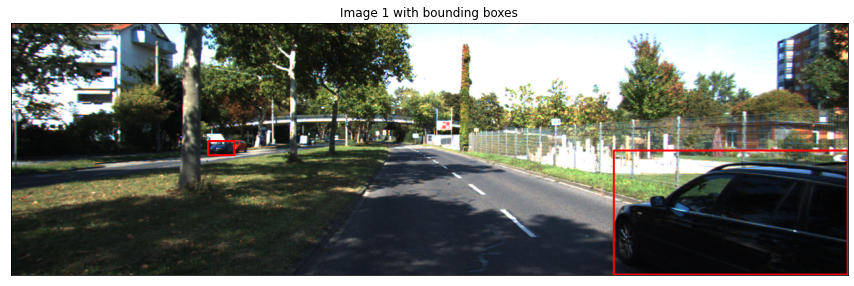

In [14]:
filepath="/content/drive/MyDrive/ECSE_415/Final_project/dataset/0003.txt"

bboxes = parse(filepath)

image = add_bbox(video_sequence[0], bboxes[0])

plt.figure(figsize=(15,15))
plt.title("Image 1 with bounding boxes"), plt.xticks([]), plt.yticks([])
plt.imshow(image)

In [16]:
print(bboxes[0])

[array([   0.    ,  894.7683,  190.6503, 1241.    ,  374.    ],
      dtype=float32), array([  2.     , 292.43732, 176.91368, 331.77728, 197.46696],
      dtype=float32)]
